In [152]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
import torch

In [153]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [154]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'D:/Masrafe/Coding/Git_Hub_code/ml_project/road_damage/pothole_detection_CNN-main/pothole_detection_CNN-main/Dataset',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1530 files belonging to 3 classes.


In [155]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [156]:
len(dataset)

48

In [157]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 2 2 2 2 0 2 1 0 0 0 0 0 2 1 1 0 1 2 0 1 0 2 2 2 2 0 0 1]


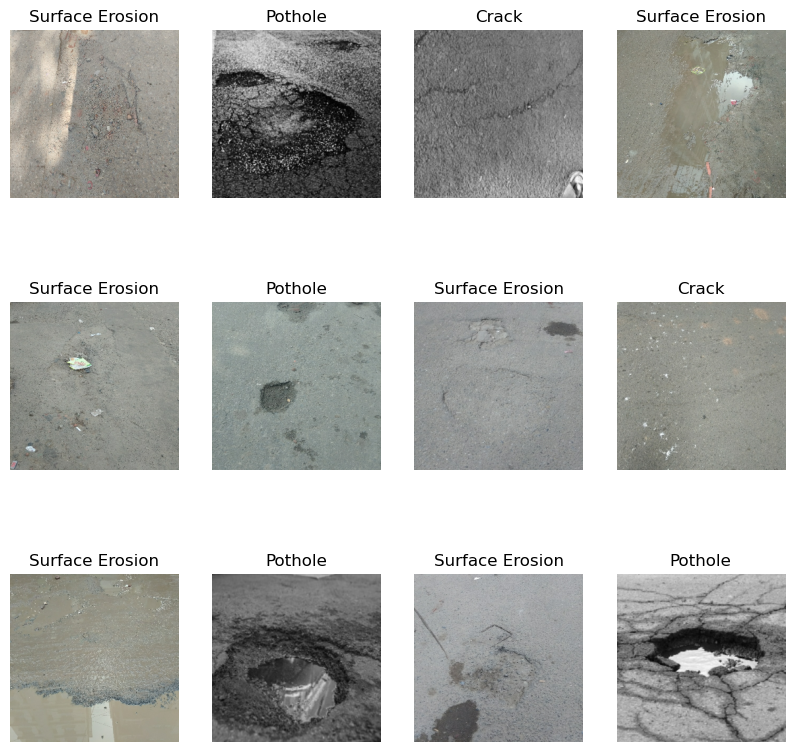

In [158]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [159]:
train_size = 0.8
len(dataset)*train_size

38.400000000000006

In [160]:
train_data = dataset.take(38)
len(train_data)

38

In [161]:
test_data = dataset.skip(38)
len(test_data)

10

In [162]:
validation_size = 0.1
len(dataset)*validation_size

4.800000000000001

In [163]:
validation_data  = test_data.take(4)
len(validation_data)

4

In [164]:
test_data = test_data.skip(4)
len(test_data)

6

In [165]:
# Dataset split function
def get_dataset_partition(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds


In [166]:
train_data, validation_data, test_data = get_dataset_partition(dataset)

In [167]:
len(train_data)
len(validation_data)
len(test_data)

6

In [168]:
# train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# validation_data = validation_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
# test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Cache, shuffle and prefetch
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [169]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [170]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [171]:
# Model builders
def build_vgg19_model():
    base = tf.keras.applications.VGG19(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [172]:
def build_resnet50_model():
    base = tf.keras.applications.ResNet50(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [173]:
def build_efficientnet_model():
    base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [174]:
def build_mobilenet_model():
    base = tf.keras.applications.MobileNetV2(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [175]:
#model = build_vgg19_model()

In [176]:
#model = build_mobilenet_model()

In [177]:
#model = build_resnet50_model()

In [178]:
model = build_efficientnet_model()

In [179]:
# n_classes = 3
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
# model = models.Sequential([
#     resize_and_rescale,
#     data_augmentation,
#     layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Conv2D(64, (3,3), activation='relu'),
#     layers.MaxPooling2D((2,2)),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(n_classes, activation='softmax')
# ])
# model.build(input_shape=input_shape)

In [180]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [181]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [182]:
# history = model.fit(
#     train_data,
#     epochs=EPOCH,
#     batch_size=BATCH_SIZE,
#     verbose = 1,
#     validation_data=validation_data
# )

# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 50s 959ms/step - accuracy: 0.3674 - loss: 1.1591 - val_accuracy: 0.4180 - val_loss: 1.0823
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 831ms/step - accuracy: 0.3864 - loss: 1.0973 - val_accuracy: 0.4180 - val_loss: 1.0772
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 823ms/step - accuracy: 0.4180 - loss: 1.0790 - val_accuracy: 0.4180 - val_loss: 1.0757
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 819ms/step - accuracy: 0.4265 - loss: 1.0811 - val_accuracy: 0.4180 - val_loss: 1.0753
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 810ms/step - accuracy: 0.4250 - loss: 1.0796 - val_accuracy: 0.4180 - val_loss: 1.0763
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 820ms/step - accuracy: 0.4387 - loss: 1.0776 - val_accuracy: 0.4180 - val_loss: 1.0735
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 832ms/step - accuracy: 0.4173 - loss: 1.0923 - val_accuracy: 0.4180 - val_loss: 1.0730
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 34s 891ms/step - accuracy: 0.4330 - loss: 1.0798 - val_accu

In [183]:
scores = model.evaluate(test_data)
scores

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step - accuracy: 0.3996 - loss: 1.0821


[1.0921316146850586, 0.3854166567325592]

In [184]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 38}

In [185]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [186]:
history.history['accuracy']

[0.37603306770324707,
 0.404132217168808,
 0.40578511357307434,
 0.4223140478134155,
 0.42561984062194824,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.4239669442176819,
 0.42396694

In [187]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

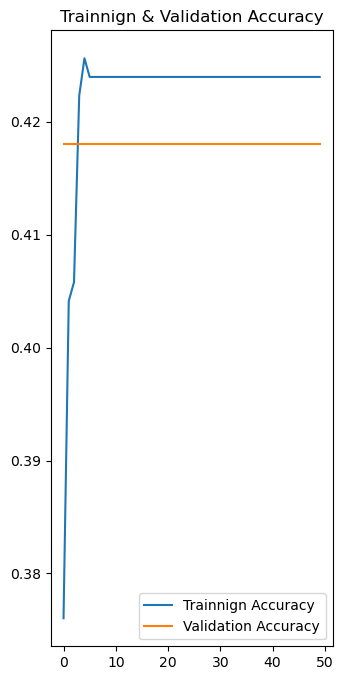

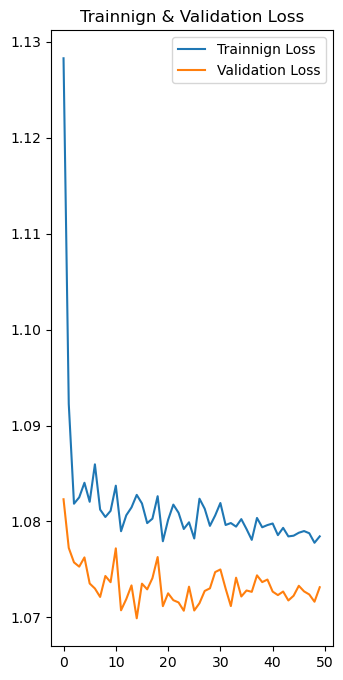

In [188]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [189]:
model.evaluate(test_data)

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 705ms/step - accuracy: 0.3996 - loss: 1.0821


[1.0921316146850586, 0.3854166567325592]

First image to predict
First image actual label:  Crack
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Label:  Surface Erosion


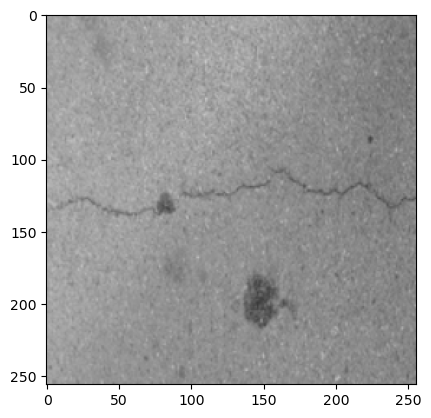

In [190]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [191]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    
    predicted_calss = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)
    
    return predicted_calss, confidence 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
42.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
42.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
42.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
42.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
42.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
42.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
42.19
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
42.2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
42.19


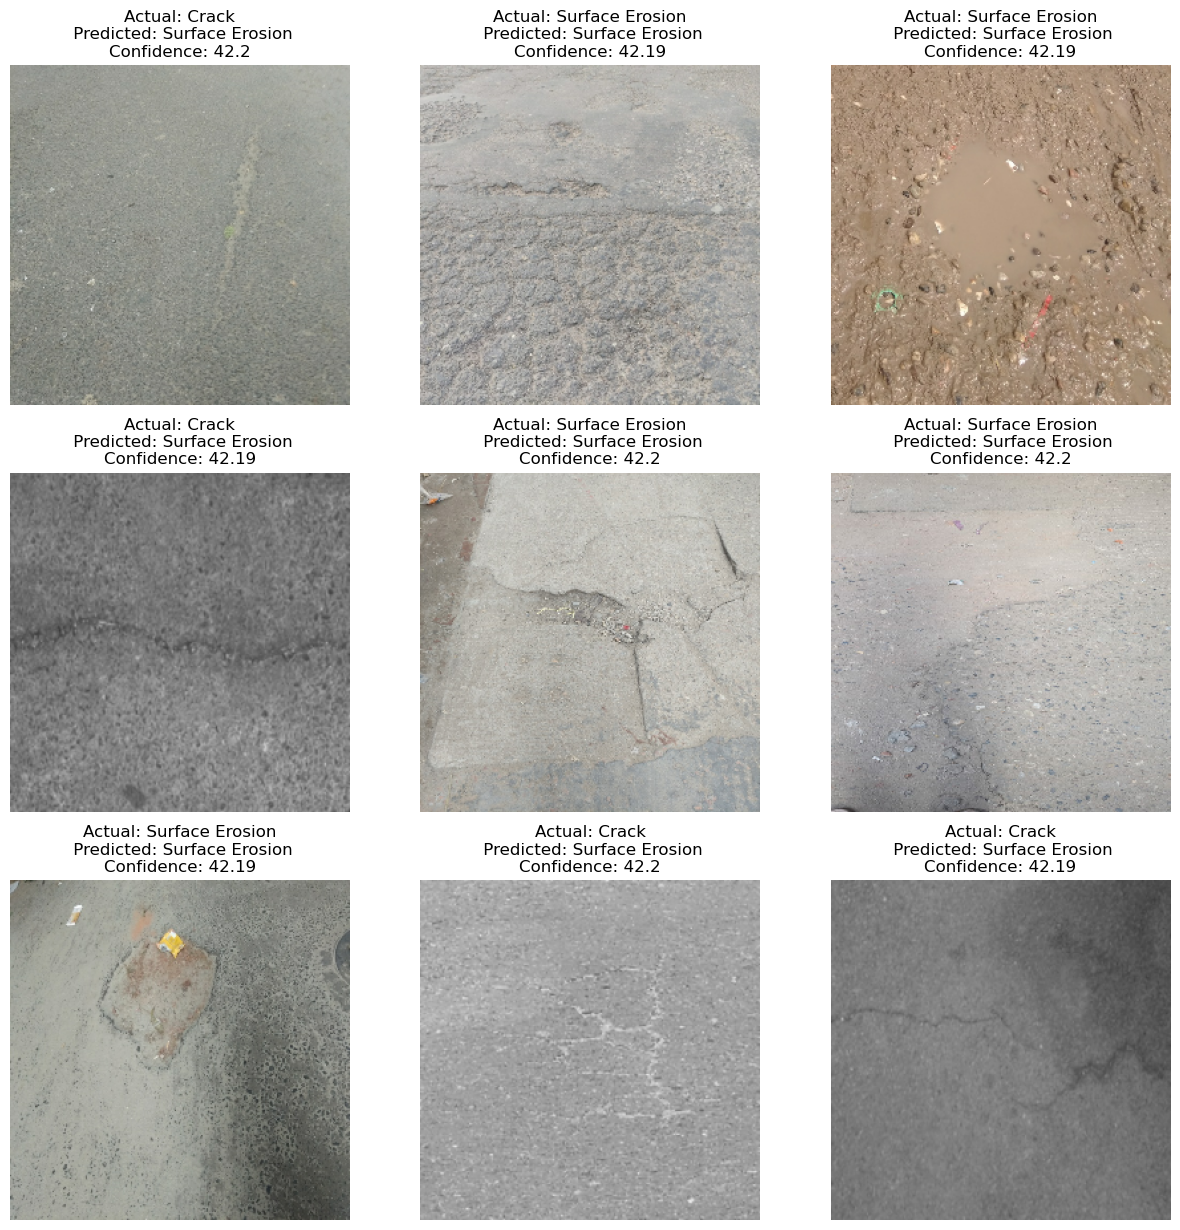

In [192]:

plt.figure(figsize=(15, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, connfidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}\n Predicted: {predicted_class}\nConfidence: {connfidence}")
        print(connfidence)
        plt.axis("off")

In [193]:
confidence_threshold = 0.8
if connfidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {connfidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 42.19


In [194]:
from sklearn.metrics import classification_report, f1_score
import numpy as np

#Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

#Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

#Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 841ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 775ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 778ms/step
F1 Score (macro): 0.18546365914786966
F1 Score (weighted): 0.2144423558897243

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.00      0.00      0.00        65
        Pothole       0.00      0.00      0.00        53
Surface Erosion       0.39      1.00      0.56        74

       accuracy                           0.39       192
      macro avg       0.13      0.33      0.19       192
   weighted avg       0.15      0.39      0.21       192



d:\Masrafe\Coding\python\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Masrafe\Coding\python\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Masrafe\Coding\python\anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
